In [272]:
import torch, torch.functional as F
from torch import nn, tensor
from fastcore.all import *
from math import sqrt

In [273]:
class MoeEinops(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim, n_exp, topk):
        store_attr()
        super().__init__()
        self.ns = nn.Parameter(torch.randn(n_exp, in_dim))
        self.w1 = nn.Parameter(torch.randn(n_exp, h_dim, in_dim))
        self.w2 = nn.Parameter(torch.randn(n_exp, out_dim, h_dim))
        self.act = nn.ReLU()
        
    def forward(self, x):
        probs, indices = torch.matmul(x, self.ns.T).topk(self.topk)
        probs = torch.softmax(probs, dim=-1)
        x = torch.einsum('bx,bkyx -> bky', x, self.w1[indices])
        x = torch.einsum('bkx,bkyx -> bky', self.act(x), self.w2[indices])
        return torch.einsum('bky,bk -> by', x, probs)

In [274]:
in_dim = 1024
h_dim = 1024
out_dim = 1024
n_exp = 16
bs = 32
topk=1

model = MoeEinops(in_dim, out_dim, h_dim, n_exp, topk).cuda()

In [275]:
from FastFF.models import moe

model2 = moe.MoE(in_dim, out_dim, n_exp, topk, hidden_dim=h_dim).cuda()

# copy all parameters 
model2.gate[0].weight = model.ns
model2.experts[0][0].weight.shape
for i, e in enumerate(model2.experts):
    e[0].weight = nn.Parameter(model.w1[i])
    e[2].weight = nn.Parameter(model.w2[i])
    e[0].bias=nn.Parameter(e[0].bias*0)
    e[2].bias=nn.Parameter(e[2].bias*0)

In [276]:
x = torch.randn(bs, in_dim).cuda()

In [277]:
sim = torch.isclose(model(x), model2(x))
(sim==False).sum()/(sim==True).sum()

tensor(0.0197, device='cuda:0')

In [278]:
%timeit -n 100 with torch.no_grad(): model(x)

833 µs ± 253 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [279]:
%timeit -n 100  with torch.no_grad(): model2(x)

4.87 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## FFF

In [297]:
def binary(x, bits):
    'converts integer vector into binary with number of `bits`'
    mask = 2**torch.arange(bits, device=x.device, dtype=x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).byte()

class FFF(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim, depth, topk, save_probs=True):
        store_attr()
        super().__init__()
        self.n = 2**depth
        self.nodes = nn.Parameter(torch.randn(self.n-1, in_dim))
        self.w1 = nn.Parameter(torch.randn(self.n, h_dim, in_dim))
        self.w2 = nn.Parameter(torch.randn(self.n, out_dim, h_dim))
        self.act = nn.ReLU()
        self.tree_act = nn.LogSigmoid()
        self.t = self.init_t_()
        self.s = self.init_s_()
        
    def init_t_(self):
        tree, res = torch.eye(self.n), []
        for _ in range(self.depth): 
            res.append(tree)
            tree = tree.view(self.n, -1, 2).sum(-1)
        return nn.Parameter(torch.cat(list(reversed(res)),dim=1), False)

    def init_s_(self):
        s = torch.eye(self.n-1)
        return nn.Parameter(torch.stack([s,-s], dim=2).view(self.n-1,2*(self.n-1)), False)
    
    def forward(self, x):
        bs = x.shape[0]
        if model.training:
            z = x.matmul(self.nodes.T).matmul(self.s)
            z = self.tree_act(z).matmul(self.t.T)
            if self.save_probs: self.probs = torch.softmax(z,-1)
            probs, indices = z.topk(self.topk)
            probs = torch.softmax(probs, dim=-1)
        else:
            indices = torch.zeros(bs, dtype=torch.long, device=x.device)
            for _ in range(self.depth):
                indices = indices*2 + 1 + (torch.einsum("b i, b i -> b", x, self.nodes[indices])<0).long()
            indices = indices[:,None] - self.n+1
            probs = torch.ones(bs,1)
        x = torch.einsum('bx, bkyx -> bky', x, self.w1[indices])
        x = torch.einsum('bkx, bkyx -> bky', self.act(x), self.w2[indices])
        return torch.einsum('bky, bk -> by', x, probs) if probs.shape[1]>1 else x[:,0]

In [298]:
d = 4
fff = FFF(in_dim, out_dim, h_dim, d, topk).cuda()
fff2 = moe.FFF(in_dim, out_dim,d, topk, h_dim, save_probs=False).cuda()

In [282]:
%timeit with torch.no_grad(): model(x)

980 µs ± 367 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [283]:
%timeit with torch.no_grad(): model2(x)

4.48 ms ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [284]:
%timeit with torch.no_grad(): fff(x)

990 µs ± 310 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [285]:
%timeit with torch.no_grad(): fff2(x)

3.71 ms ± 83.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [300]:
from fastai.callback.wandb import *
from FastFF.performance import *
from fastai.vision.all import *

h_dim = 32
d = 4
topk = 2
bs = 256

model = FFF(28*28, 10, h_dim, d, topk)
cbs = [ProbsDistrCB(), GetGradCB([model.nodes, model.w1])]
Learner(get_mnist_dls(bs), model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(10, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.324595,1.996237,0.479800,00:24
1,0.600031,0.542521,0.838300,00:29
2,0.348043,0.315571,0.913900,00:31
3,0.300661,0.330586,0.914500,00:32
4,0.280337,0.277621,0.926100,00:32
5,0.228776,0.243572,0.934800,00:33
6,0.238865,0.239752,0.936300,00:32
7,0.183861,0.220526,0.942800,00:33
8,0.172563,0.210222,0.944800,00:34
9,0.182175,0.212213,0.945000,00:35


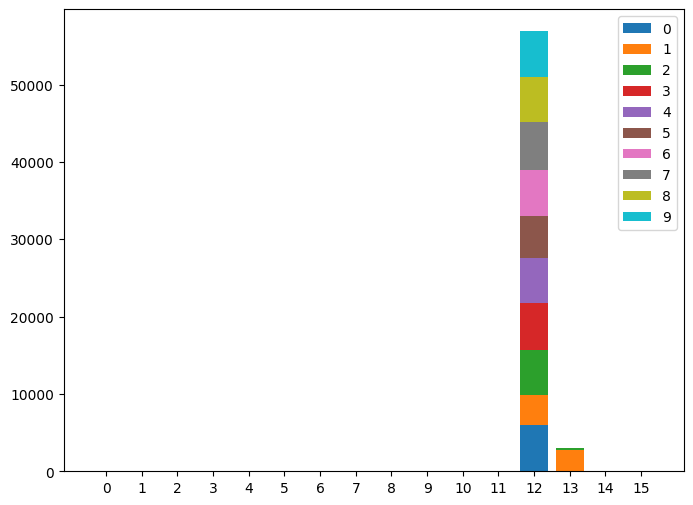

In [301]:
cbs[0].show(-1)